<a href="https://colab.research.google.com/github/DavideScassola/xai-labs/blob/main/./SHAP/shap_README.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to SHAP
This notebook is a sligthly modified version of the readme of the [official SHAP github page](https://github.com/shap/shap) and takes inspiration from other notebooks of the same repo.

<p align="center">
  <img src="https://raw.githubusercontent.com/shap/shap/master/docs/artwork/shap_header.svg" width="800" />
</p>


## Install

[SHAP](https://shap.readthedocs.io/en/latest/) can be installed from either [PyPI](https://pypi.org/project/shap) or [conda-forge](https://anaconda.org/conda-forge/shap):

<pre>
pip install shap
<i>or</i>
conda install -c conda-forge shap
</pre>


In [16]:
#!pip install shap
#!pip install xgboost
#!pip install transformers
#!pip install datasets

## Tree ensemble example (XGBoost/LightGBM/CatBoost/scikit-learn/pyspark models)

While SHAP can explain the output of any machine learning model, there are a high-speed exact algorithm for tree ensemble methods (see [Nature MI paper](https://rdcu.be/b0z70)). Fast C++ implementations are supported for *XGBoost*, *LightGBM*, *CatBoost*, *scikit-learn* and *pyspark* tree models:


In [26]:
import xgboost
import shap

# train an XGBoost model
X, y = shap.datasets.california()
print('predictors: ', X.columns)
model = xgboost.XGBRegressor().fit(X, y)

predictors:  Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')


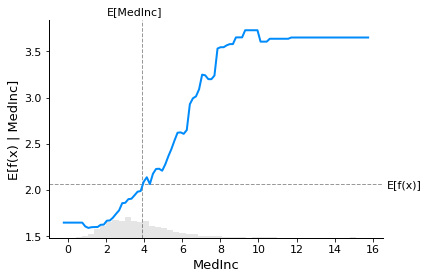

In [28]:
# make a standard partial dependence plot
_ = shap.partial_dependence_plot(
    "MedInc",
    model.predict,
    X,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False
)

In [29]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)

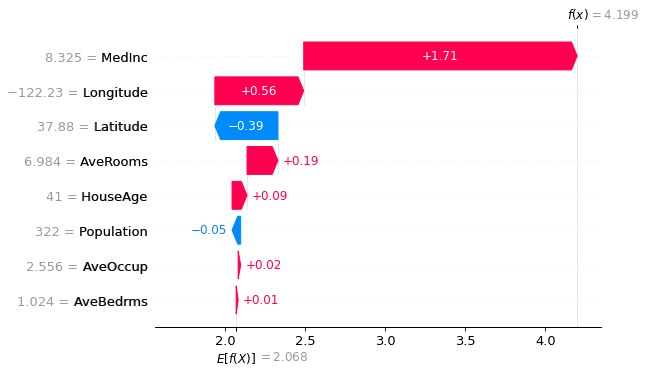

In [30]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue. Another way to visualize the same explanation is to use a force plot (these are introduced in [Nature BME paper](https://rdcu.be/baVbR))

In [3]:
# visualize the first prediction's explanation with a force plot
shap.initjs()
shap.plots.force(shap_values[0])

If we take many force plot explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset (in the notebook this plot is interactive):

In [4]:
# visualize all the training set predictions
shap.initjs()
shap.plots.force(shap_values[:500])

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. Since SHAP values represent a feature's responsibility for a change in the model output, the plot below represents the change in predicted house price as the latitude changes. Vertical dispersion at a single value of latitude represents interaction effects with other features. To help reveal these interactions we can color by another feature. If we pass the whole explanation tensor to the `color` argument the scatter plot will pick the best feature to color by. In this case it picks longitude.

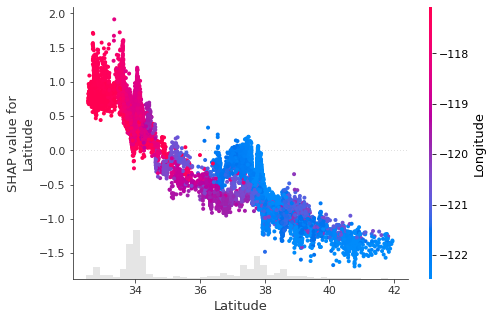

In [5]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.initjs()
shap.plots.scatter(shap_values[:, "Latitude"], color=shap_values)

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low). This reveals for example that higher median incomes improves the predicted home price.

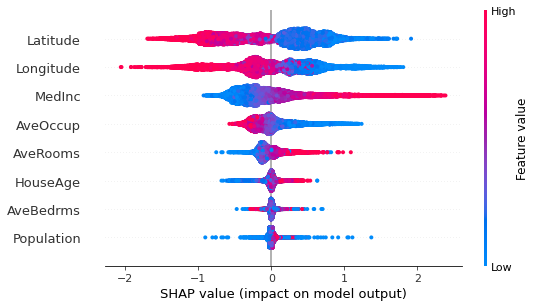

In [6]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs):



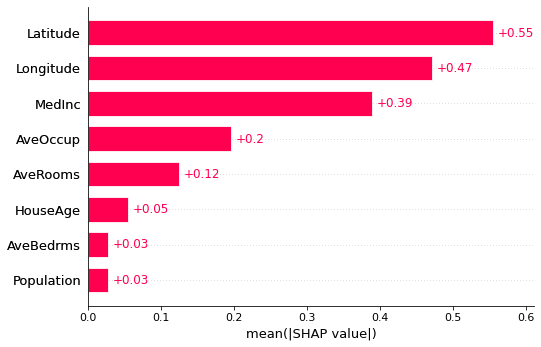

In [7]:
shap.plots.bar(shap_values)

## SHAP Interaction Values

SHAP interaction values are a generalization of SHAP values to higher order interactions. Fast exact computation of pairwise interactions are implemented for tree models with `shap.TreeExplainer(model).shap_interaction_values(X)`. This returns a matrix for every prediction, where the main effects are on the diagonal and the interaction effects are off-diagonal. These values often reveal interesting hidden relationships, such as how the increased risk of death peaks for men at age 60 (see the NHANES notebook for details):

In [33]:
shap.TreeExplainer(model).shap_interaction_values(X[0:1])

array([[[ 1.7428529e+00,  7.6666713e-02, -2.5453642e-02,  2.4387151e-02,
          6.5937880e-03, -3.6397446e-02, -4.7932446e-02, -3.2538354e-02],
        [ 7.6666892e-02,  7.2726317e-02,  3.3815928e-02, -6.1973715e-03,
          1.0865323e-02, -3.3355169e-02, -3.9899006e-02, -2.0986170e-02],
        [-2.5454044e-02,  3.3815924e-02,  2.0108102e-01,  1.9021663e-03,
          1.5004922e-02,  3.7124339e-03, -2.8182715e-02, -9.1092288e-03],
        [ 2.4387479e-02, -6.1973855e-03,  1.9021705e-03, -4.5958860e-03,
         -4.7872886e-03,  2.0412942e-03, -6.5613836e-03,  6.2654912e-03],
        [ 6.5937042e-03,  1.0865297e-02,  1.5004940e-02, -4.7872970e-03,
         -6.5325849e-02, -4.1397568e-03, -1.1732906e-02, -3.8424134e-04],
        [-3.6397099e-02, -3.3355139e-02,  3.7125051e-03,  2.0413003e-03,
         -4.1397624e-03,  3.8140930e-02,  2.7766243e-02,  1.7950088e-02],
        [-4.7932863e-02, -3.9899066e-02, -2.8182775e-02, -6.5613906e-03,
         -1.1732927e-02,  2.7766366e-02, -1.4

## Natural language example (transformers)

SHAP has specific support for natural language models like those in the Hugging Face transformers library. By adding coalitional rules to traditional Shapley values we can form games that explain large modern NLP model using very few function evaluations. Using this functionality is as simple as passing a supported transformers pipeline to SHAP:

In [35]:
import transformers
import shap

# load a transformers pipeline model
model = transformers.pipeline('sentiment-analysis', return_all_scores=True)

# explain the model on two sample inputs
explainer = shap.Explainer(model)
shap_values = explainer(["What a great movie! ...if you have no taste."])

# visualize the first prediction's explanation for the POSITIVE output class
shap.plots.text(shap_values[0, :, "POSITIVE"])


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/home/davide/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/davide/.local/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:15, 15.37s/it]               


## Model agnostic example with KernelExplainer (explains any function)

Kernel SHAP uses a specially-weighted local linear regression to estimate SHAP values for any model. Below is a simple example for explaining a multi-class SVM on the classic iris dataset.

In [36]:
import sklearn
import shap
from sklearn.model_selection import train_test_split

# print the JS visualization code to the notebook
shap.initjs()

# train a SVM classifier
X_train,X_test,Y_train,Y_test = train_test_split(*shap.datasets.iris(), test_size=0.2, random_state=0)
svm = sklearn.svm.SVC(kernel='rbf', probability=True)
svm.fit(X_train, Y_train)

# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(svm.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(X_test, nsamples=100)

# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][:,0], X_test.iloc[0,:], link="logit")


Using 120 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/30 [00:00<?, ?it/s]

In [37]:
shap.force_plot(explainer.expected_value[0], shap_values[0][:,1], X_test.iloc[0,:], link="logit")

In [38]:
shap.force_plot(explainer.expected_value[0], shap_values[0][:,2], X_test.iloc[0,:], link="logit")

The above explanation shows four features each contributing to push the model output from the base value (the average model output over the training dataset we passed) towards zero. If there were any features pushing the class label higher they would be shown in red.

If we take many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset. This is exactly what we do below for all the examples in the iris test set:

In [39]:
# plot the SHAP values for the Setosa output of all instances
shap.force_plot(explainer.expected_value[0], shap_values[:,:,0], X_test, link="logit")

<a id="correlated_features"></a>
## Dealing with correlated features

In [40]:
X_adult, y_adult = shap.datasets.adult()

# train XGBoost model
model = xgboost.XGBClassifier(n_estimators=100, max_depth=2).fit(X_adult, y_adult * 1)

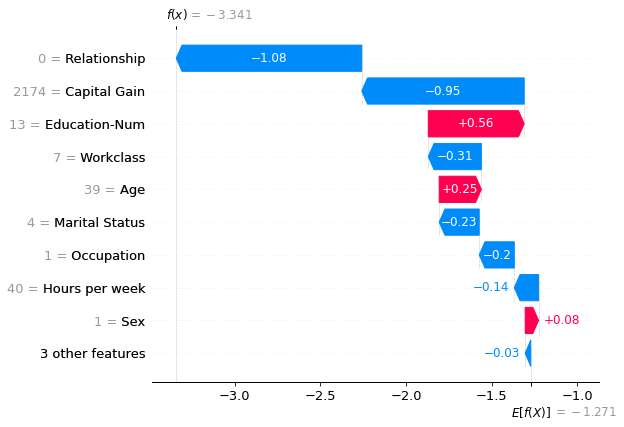

In [41]:
explainer = shap.Explainer(model)
shap_values = explainer(X_adult)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [59]:
clustering = shap.utils.hclust(X_adult, y_adult)

13it [00:52,  5.85s/it]                        


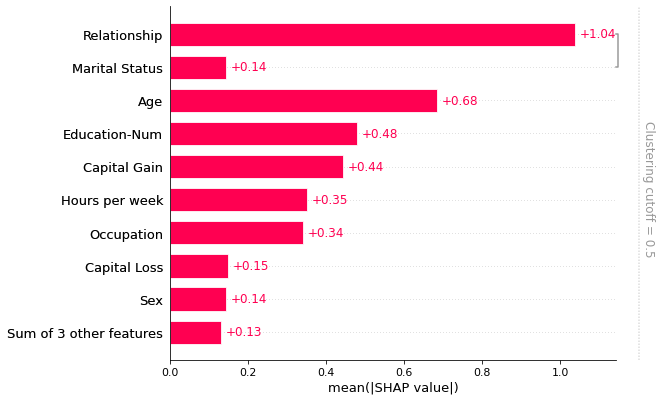

In [60]:
shap.plots.bar(shap_values, clustering=clustering)

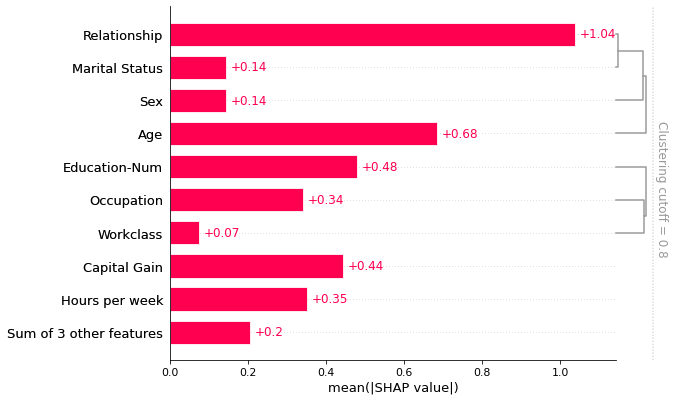

In [61]:
shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=0.8)

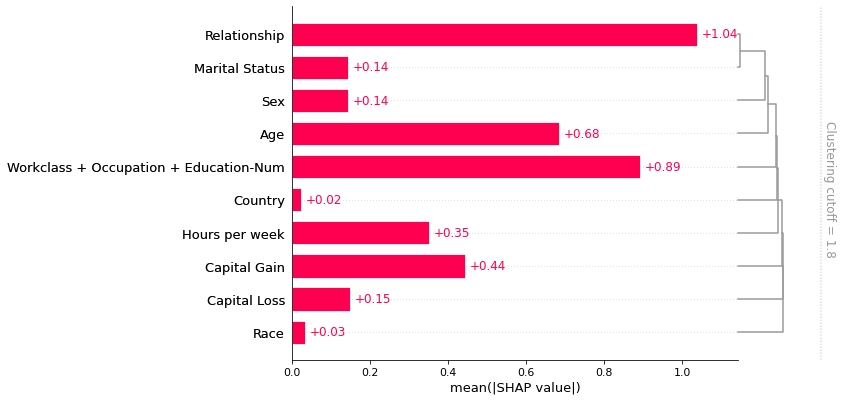

In [62]:
shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=1.8)

## references

The algorithms and visualizations used in this package came primarily out of research in [Su-In Lee's lab](https://suinlee.cs.washington.edu) at the University of Washington, and Microsoft Research.
- General use of SHAP: [NeurIPS paper](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) ([bibtex](https://raw.githubusercontent.com/shap/shap/master/docs/references/shap_nips.bib)).
- TreeExplainer: [Nature Machine Intelligence paper](https://www.nature.com/articles/s42256-019-0138-9) ([bibtex](https://raw.githubusercontent.com/shap/shap/master/docs/references/tree_explainer.bib); [free access](https://rdcu.be/b0z70)).
- GPUTreeExplainer: [this article](https://arxiv.org/abs/2010.13972).
- `force_plot` visualizations and medical applications: [Nature Biomedical Engineering paper](https://www.nature.com/articles/s41551-018-0304-0) ([bibtex](https://raw.githubusercontent.com/shap/shap/master/docs/references/nature_bme.bib); [free access](https://rdcu.be/baVbR)).